# TinyML 'Hello World' 시작하기: 모델 구축과 훈련


모든 프로젝트의 시작점. 'Hello world'를 시작해보자. 본 과정을 진행하며 모델을 직접 만들고 훈련시킨 후 마이크로컨트롤러 프로그램에 통합하는 것까지 차례차례 수행해보자.


In [2]:
# Base Setup


# import library
import os
import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc as matplot_rc


# Path setup
main_path = '/Users/jaewone/developer/tflm/1.create_model'
images_path = os.path.join(main_path, 'images')
os.makedirs(images_path, exist_ok=True)

sys.path.append(main_path)


# graph setup for clean graph
%matplotlib inline
matplot_rc('axes', labelsize=14)
matplot_rc('xtick', labelsize=12)
matplot_rc('ytick', labelsize=12)

def show_and_save_graph(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_name + "." + fig_extension)
    print("Save image:", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    plt.show()


# Set seed
random_seed = 42
np.random.seed(random_seed)

## 1. 문제 정의

문제 정의. 즉 하고자 하는 바를 먼저 정의하자.

아래와 같은 사인(sin) 함수와 유사한 **'사인파'** 데이터가 존재할 때 x값을 통하여 결과값인 y를 예측하는 모델을 만드는 것이다.

예를 들어 아래와 같은 사인파가 있을 때 입력값으로 x=0이 주어졌을 때 y=0이라는 결과값을 반환하는 모델을 만드는 것이 목표이다.


Save image: sin_graph


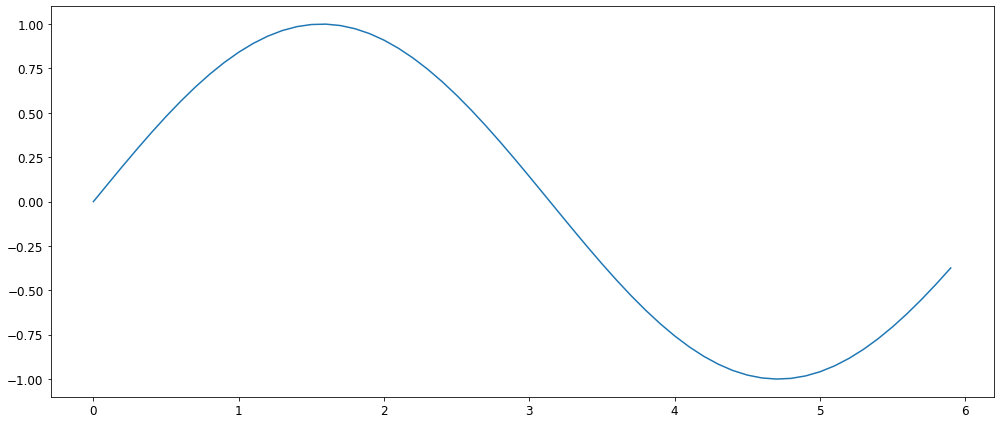

In [3]:
plt.figure(figsize=(14, 6))
x = np.arange(0, 6, 0.1)
y = np.sin(x)
plt.plot(x, y)
show_and_save_graph("sin_graph")

먼저 sine 형태의 데이터를 생성해보자.


Save image: simple_sin_plot


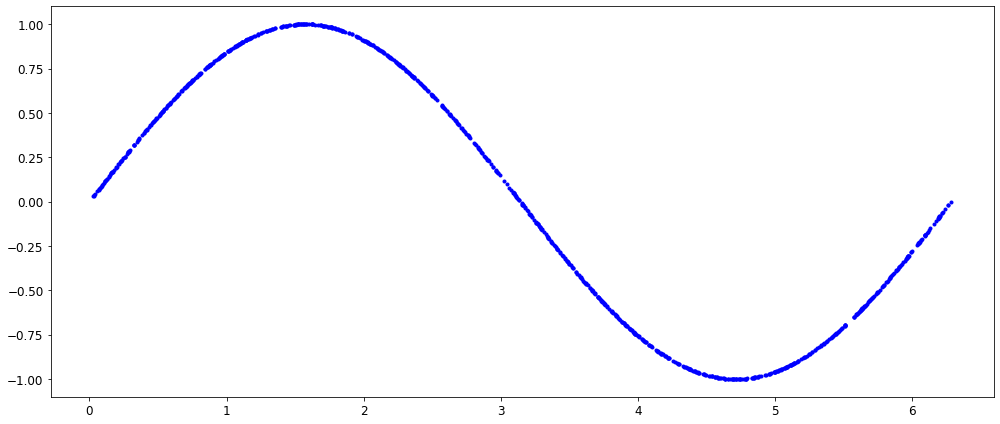

In [4]:
# Create sine dataset
plt.figure(figsize=(14, 6))

# 아래의 값만큼 데이터 샘플을 생성할 것이다.
SAMPLES = 1000

# 사인파 진폭의 범위인 0~2π 내에서 균일하게 분포된 난수 집합을 생성한다.
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# 값을 섞어서 생성된 값들이 순서를 따르지 않도록 한다.
np.random.shuffle(x_values)

# 해당 사인값을 계산한다
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
show_and_save_graph("simple_sin_plot")

sine 그래프에 노이즈를 추가하여 실제 데이터와 유사한 데이터를 생성하자.


Save image: sine_plot_with_noise


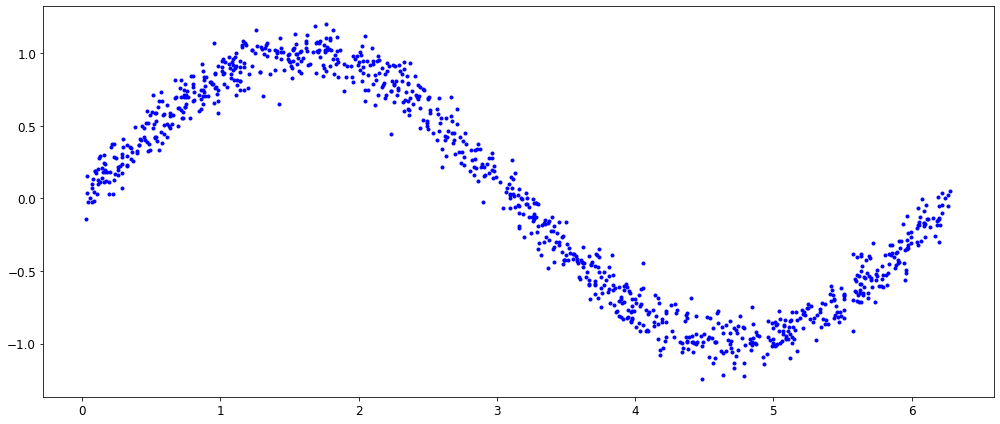

In [5]:
# 각 y 값에 임의의 작은 숫자를 추가한다.
y_values += 0.1 * np.random.randn(*y_values.shape)

# 그래프를 생성한다.
plt.figure(figsize=(14, 6))
plt.plot(x_values, y_values, 'b.')
show_and_save_graph('sine_plot_with_noise')

데이터를 train, validation, test로 나눈다.


Save image: sine_plot_with_noise_split


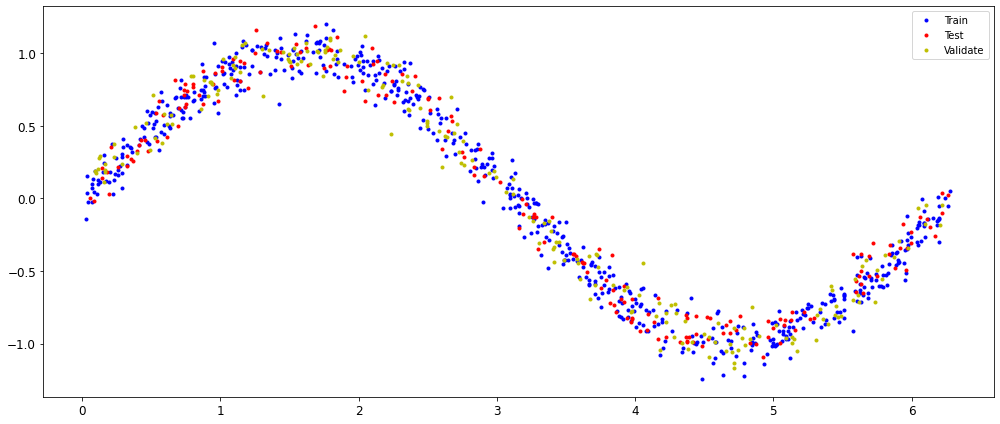

In [6]:
# 훈련에 60%, 테스트에 20%, 검증에  20%를 사용한다.
# 각 항목의 인덱스를 계산한다.
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# np.split을 사용하여 데이터를 세 부분으로 자른다.
# np.split의 두 번째 인수는 데이터가 분할되는 인덱스 배열이며,
# 우리는 두 개의 인덱스를 제공하므로 데이터는 세 개의 덩어리로 나뉠 것이다.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# 분할한 데이터를 합쳤을 때 원래의 사이즈와 같은지 재확인한다.
assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

# 분할된 각 데이터들을 다른 색상으로 그래프에 표시한다.
plt.figure(figsize=(14, 6))
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
show_and_save_graph('sine_plot_with_noise_split')

입력된 x값을 통해 y값을 예측하는 모델을 생성해보자.


In [7]:
# Create model1
# from tensorflow.keras import layers

# # Set model
# model_1 = tf.keras.Sequential([
#     layers.Dense(16, activation='relu', input_shape=(1,)),
#     layers.Dense(1)
# ])

# # compile model
# model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# # train model
# history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
#                         validation_data=(x_validate, y_validate))

# # 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다.
# loss = history_1.history['loss']
# val_loss = history_1.history['val_loss']

# epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(14, 6))
# plt.plot(epochs, loss, 'g.', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# show_and_save_graph('model_1_losses')

# # 모델을 사용하여 검증 데이터로부터 예측값 생성
# predictions = model_1.predict(x_train)

# # 테스트 데이터와 함께 예측값을 그래프로 표현
# plt.figure(figsize=(14, 6))
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(x_test, y_test, 'b.', label='Actual')
# plt.plot(x_train, predictions, 'r.', label='Predicted')
# plt.legend()
# show_and_save_graph('model_1_predictions')

"""
모델이 0 <= x <= 1.1 범위에서 적합한 예측을 수행하지만 나머지 부분에서 대체적으로 적합하지 않는 것을 확인할 수 있다.

모델에 사인파 함수의 전체 복잡성을 학습할 수있는 충분한 Capacity가 없기 때문에 지나치게 단순한 방식으로만 예측을 수행했기 때문에 1.1 이상의 범위에서 충분한 적합도가 보이지 않은 것으로 보인다.

이에 모델을 더 크게 만들어 Capacity를 증가시켜보자.
"""

'\n모델이 0 <= x <= 1.1 범위에서 적합한 예측을 수행하지만 나머지 부분에서 대체적으로 적합하지 않는 것을 확인할 수 있다.\n\n모델에 사인파 함수의 전체 복잡성을 학습할 수있는 충분한 Capacity가 없기 때문에 지나치게 단순한 방식으로만 예측을 수행했기 때문에 1.1 이상의 범위에서 충분한 적합도가 보이지 않은 것으로 보인다.\n\n이에 모델을 더 크게 만들어 Capacity를 증가시켜보자.\n'

In [8]:
from tensorflow.keras import layers

model_2 = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(1,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

# 표준 옵티마이저 및 손실 함수를 사용하여 회귀 모델을 컴파일
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                        validation_data=(x_validate, y_validate))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/600


2023-09-29 08:00:29.312552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-29 08:00:29.312681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-29 08:00:29.463761: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-29 08:00:29.734641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 15ms/step - loss: 0.6164 - mae: 0.6861 - val_loss: 0.4796 - val_mae: 0.6122
Epoch 2/600
10/38 [======>.......................] - ETA: 0s - loss: 0.4199 - mae: 0.5636

2023-09-29 08:00:30.445720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 0s 8ms/step - loss: 0.3879 - mae: 0.5319 - val_loss: 0.3994 - val_mae: 0.5363
Epoch 3/600
38/38 [==============================] - 0s 11ms/step - loss: 0.3228 - mae: 0.4821 - val_loss: 0.3303 - val_mae: 0.4894
Epoch 4/600
38/38 [==============================] - 0s 8ms/step - loss: 0.2685 - mae: 0.4423 - val_loss: 0.2716 - val_mae: 0.4467
Epoch 5/600
38/38 [==============================] - 0s 8ms/step - loss: 0.2232 - mae: 0.4040 - val_loss: 0.2311 - val_mae: 0.4054
Epoch 6/600
38/38 [==============================] - 0s 7ms/step - loss: 0.1905 - mae: 0.3751 - val_loss: 0.1861 - val_mae: 0.3786
Epoch 7/600
38/38 [==============================] - 0s 7ms/step - loss: 0.1695 - mae: 0.3546 - val_loss: 0.1702 - val_mae: 0.3641
Epoch 8/600
38/38 [==============================] - 0s 8ms/step - loss: 0.1590 - mae: 0.3433 - val_loss: 0.1534 - val_mae: 0.3443
Epoch 9/600
38/38 [==============================] - 0s 9ms/step - loss: 0.1495 - mae: 0.3293 

7/7 [==============================] - 0s 4ms/step - loss: 0.0142 - mae: 0.0976
Save image: model_2_predictions


2023-09-29 08:03:33.588915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

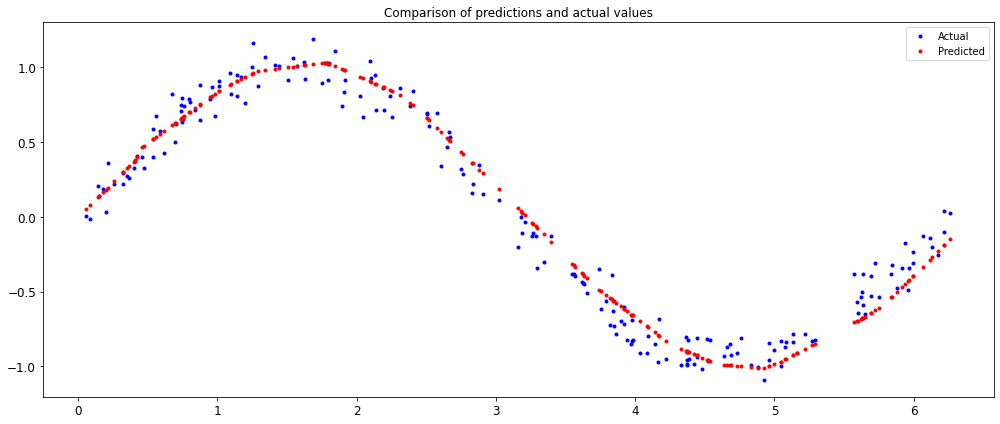

In [9]:
# 테스트 데이터셋의 손실 계산 및 출력
loss = model_2.evaluate(x_test, y_test)

# 테스트 데이터셋 기반으로 예측
predictions = model_2.predict(x_test)

# 실제값에 대한 예측 그래프
plt.clf()
plt.figure(figsize=(14, 6))
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
show_and_save_graph('model_2_predictions')

자 이제 모델이 완성되었으니 tensorflow lite 모델로 변환해보자.


In [10]:
# 양자화 없이 모델을 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# 모델을 디스크에 저장
open("sine_model.tflite", "wb").write(tflite_model)

# 양자화하여 모델을 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# 모델을 디스크에 저장
open("sine_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmpl7c10v4u/assets


2023-09-29 08:03:34.343100: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-09-29 08:03:35.669062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-09-29 08:03:35.669079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-09-29 08:03:35.670058: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmpl7c10v4u
2023-09-29 08:03:35.670698: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-09-29 08:03:35.670704: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmpl7c10v4u
2023-09-29 08:03:35.673501: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-09-29 08:03:

INFO:tensorflow:Assets written to: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmp4uadrxi7/assets


INFO:tensorflow:Assets written to: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmp4uadrxi7/assets
2023-09-29 08:03:37.125334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-09-29 08:03:37.125345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-09-29 08:03:37.125422: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmp4uadrxi7
2023-09-29 08:03:37.126046: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-09-29 08:03:37.126051: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/tmp4uadrxi7
2023-09-29 08:03:37.128200: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-09-29 08:03:37.151054: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

3008

양자화를 통해 tflite로 변환된 모델(tflite_model)과 기존 모델(model_2)의 성능을 비교해보자.


Save image: model_comparisons


<Figure size 432x288 with 0 Axes>

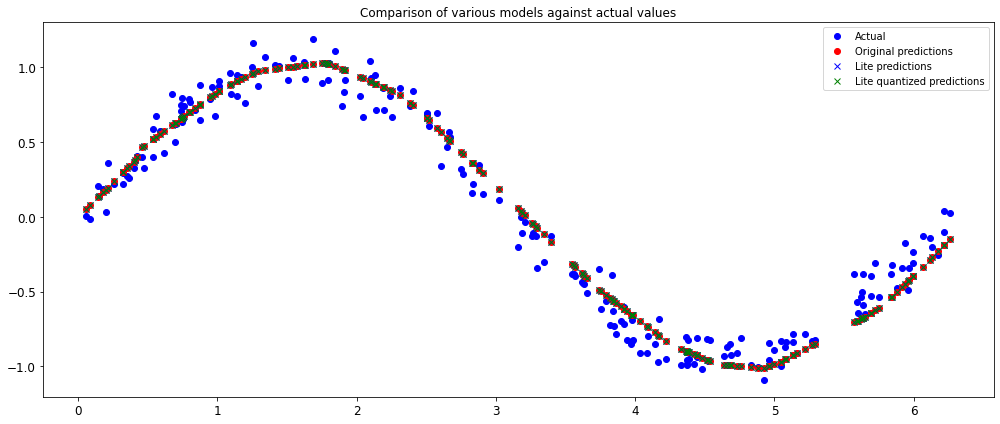

In [12]:
# 각 모델에 대한 인터프리터 인스턴스화.
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# 각 모델에 대한 메모리 할당
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# 입력과 결과 텐서에 대한 인덱스 가져오기
sine_model_input = sine_model.tensor(
    sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(
    sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(
    sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(
    sine_model_quantized.get_output_details()[0]["index"])

# 결과를 저장하기 위한 배열 생성
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

# 각 값에 대해 각 모델의 인터프리터를 실행하고 결과를 배열에 저장
for i in range(x_test.size):
    sine_model_input().fill(x_test[i])
    sine_model.invoke()
    sine_model_predictions[i] = sine_model_output()[0]

    sine_model_quantized_input().fill(x_test[i])
    sine_model_quantized.invoke()
    sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]

# 데이터가 어떻게 정렬되는지 확인
plt.clf()
plt.figure(figsize=(14, 6))
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions,
         'gx', label='Lite quantized predictions')
plt.legend()
show_and_save_graph('model_comparisons')

비교 결과 모델의 크기가 가벼워졌음에도 불구하고 정확도는 크게 떨어지지 않았음을 확인할 수 있다.


위 과정을 통해 변환된 tflite 모델을 C 소스 파일로 변환해주자. 변환된 C 소스 파일은 model_quant_tflite.txt 파일로 저장된다.


In [16]:
# xxd를 사용할 수 없을 경우, 설치한다.
# !apt-get -qq install xxd
# 파일을 C 소스파일로 저장 
import sys
sys.stdout = open('model_quant_tflite.txt','w')

!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# 소스파일을 출력
!cat sine_model_quantized.cc